In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

### Loading data
For the moment, every profile is stored in a ``pickle`` format. Let's see what the data looks like.

In [2]:
import os
import glob
files = glob.glob('profiles/*.pkl')

out = {}
for file in files:
    with open(file, 'rb') as f:
        tmp = pickle.load(f)
        out = {**out, **tmp}

print(f'{type(out)=}')
print(f'{len(out)=}')
print(sorted(out.keys()))

type(out)=<class 'dict'>
len(out)=361
['SMP_1119', 'SMP_1120', 'SMP_1121', 'SMP_1122', 'SMP_1123', 'SMP_1124', 'SMP_1125', 'SMP_1126', 'SMP_1127', 'SMP_1128', 'SMP_1129', 'SMP_1130', 'SMP_1131', 'SMP_1132', 'SMP_1133', 'SMP_1134', 'SMP_1135', 'SMP_1136', 'SMP_1137', 'SMP_1138', 'SMP_1139', 'SMP_1140', 'SMP_1141', 'SMP_1142', 'SMP_1143', 'SMP_1144', 'SMP_1145', 'SMP_1146', 'SMP_1147', 'SMP_1212', 'SMP_1281', 'SMP_1282', 'SMP_1283', 'SMP_1284', 'SMP_1285', 'SMP_1286', 'SMP_1287', 'SMP_1288', 'SMP_1289', 'SMP_1290', 'SMP_1291', 'SMP_1292', 'SMP_1293', 'SMP_1294', 'SMP_1295', 'SMP_1296', 'SMP_1297', 'SMP_1298', 'SMP_1299', 'SMP_1301', 'SMP_1302', 'SMP_1303', 'SMP_1304', 'SMP_1305', 'SMP_1306', 'SMP_1307', 'SMP_1308', 'SMP_1309', 'SMP_1310', 'SMP_1311', 'SMP_1312', 'SMP_1313', 'SMP_1314', 'SMP_1315', 'SMP_1316', 'SMP_1317', 'SMP_1318', 'SMP_1325', 'SMP_1326', 'SMP_1328', 'SMP_1329', 'SMP_1330', 'SMP_1331', 'SMP_1332', 'SMP_1333', 'SMP_1334', 'SMP_1335', 'SMP_1336', 'SMP_1337', 'SMP_1338', '

We have a dictionary where every key refers to a SMP profile. Every profile is a dataframe with as many rows as there is depths observation, and columns give information on the properties of the snow.

In [3]:
profile = out['SMP_1399']
profile.columns

Index(['distance', 'force_median', 'fmax', 'L2012_lambda', 'L2012_f0',
       'L2012_delta', 'L2012_L', 'npeaks', 'B2009_psi', 'gradient_psi',
       'delta_bellaire', 'delta_bellairef5', 'layer'],
      dtype='object')

Plotting one profile shows us where the weak layer is with respect to some other parameters:

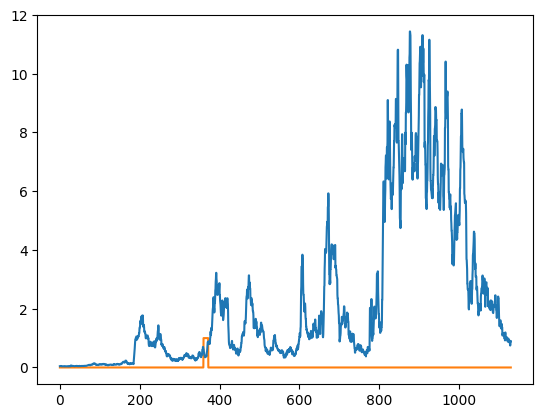

In [4]:
plt.plot(profile['distance'], profile['fmax'])
plt.plot(profile['distance'], profile['layer'] == 'WL', zorder=0)

Looking at multiple profiles in this manner, we learn that:
- For a given survey, the weak layer is relatively constant. Therefore, we cannot use depth solely as an indicator as it won't do a really good job at generalizing. 
- The depths are varying - this will need to be accounted for when using a U-Net or some other DL architecture.

Let's define some helper functions that will help us manipulate our data. For now, computing a few rolling windows of the available data will help us easily generate features to work with.

In [5]:
# we pick 200 profiles randomly so create the training data and keep some other profile for validating
import random

keys = set(out.keys())
train_keys = set(random.sample(keys, 100))
val_keys = keys - train_keys

train_profiles = {k: out[k] for k in train_keys}
val_profiles = {k: out[k] for k in val_keys}

In [16]:
import pandas as pd

def rolling_windows(X, nwindow):

    rolling = X.rolling(nwindow)

    mean = rolling.mean()
    mean.columns = mean.columns + f'_mean_rolling_{nwindow}'

    std = rolling.std()
    std.columns = std.columns + f'_std_rolling_{nwindow}'

    skew = rolling.skew()
    skew.columns = skew.columns + f'_skew_rolling_{nwindow}'

    kurt = rolling.kurt()
    kurt.columns = kurt.columns + f'_kurt_rolling_{nwindow}'

    df = pd.concat([mean, std, skew, kurt], axis=1)
    df = df.fillna(0)   

    return df


def profile_to_data(profile, nwindow=None):
    X = pd.DataFrame()

    subprofile = profile.iloc[:, :-1].copy()
    subprofile = subprofile / subprofile.max()

    if nwindow is not None:
        if isinstance(nwindow, int):
            nwindow = [nwindow]
        
        for n in nwindow:
            roll = rolling_windows(subprofile, n)
            X = pd.concat([X, roll], axis=1)

    y = (profile['layer'] == 'WL').astype(int)

    return X, y

def pickle_to_data(out, nwindow=100):
    X = pd.DataFrame()
    y = pd.DataFrame()

    for key in out.keys():
        profile = out[key]

        if 'layer' not in profile.columns:
            continue 
        
        Xi, yi = profile_to_data(profile, nwindow=nwindow)
        
        X = pd.concat([X, Xi], ignore_index=True)
        y = pd.concat([y, yi], ignore_index=True)
        
    return X, y


nwindows = [10, 100, 1000]
X, y = pickle_to_data(train_profiles, nwindow=nwindows)
X = X.dropna()
y = y.loc[X.index]
X

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  ret

,distance_mean_rolling_10,force_median_mean_rolling_10,fmax_mean_rolling_10,L2012_lambda_mean_rolling_10,L2012_f0_mean_rolling_10,L2012_delta_mean_rolling_10,L2012_L_mean_rolling_10,npeaks_mean_rolling_10,B2009_psi_mean_rolling_10,gradient_psi_mean_rolling_10,...,fmax_kurt_rolling_1000,L2012_lambda_kurt_rolling_1000,L2012_f0_kurt_rolling_1000,L2012_delta_kurt_rolling_1000,L2012_L_kurt_rolling_1000,npeaks_kurt_rolling_1000,B2009_psi_kurt_rolling_1000,gradient_psi_kurt_rolling_1000,delta_bellaire_kurt_rolling_1000,delta_bellairef5_kurt_rolling_1000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213546,0.996485,0.020836,0.080038,0.000867,0.071717,0.247300,0.544739,0.008771,0.064057,0.030615,...,1.319673,7.265913,45.944097,10.794972,4.167833,2.268648,0.529385,6.508028,33.883732,385.012549
213547,0.996898,0.029454,0.108026,0.000718,0.101524,0.282952,0.576743,0.007744,0.078219,0.046191,...,1.319366,7.265025,68.542833,10.794722,4.154529,2.266765,0.528608,6.450478,34.062761,385.012549
213548,0.997312,0.043555,0.136014,0.000678,0.116407,0.298006,0.581262,0.007499,0.098566,0.110471,...,1.319059,7.262827,64.136088,10.728523,4.107048,2.263744,0.528153,11.931298,34.404582,385.012549
213549,0.997725,0.068891,0.230567,0.000590,0.212922,0.324302,0.603961,0.006852,0.160751,0.208643,...,1.431062,7.258154,448.193234,10.515890,4.051522,2.258667,0.736945,35.513616,34.424278,385.012549


For one survey, concatenating every profile results in a large amount of rows! Let's see what the data looks like.

Text(1, 0    96.951548
dtype: float64, '207041.0')

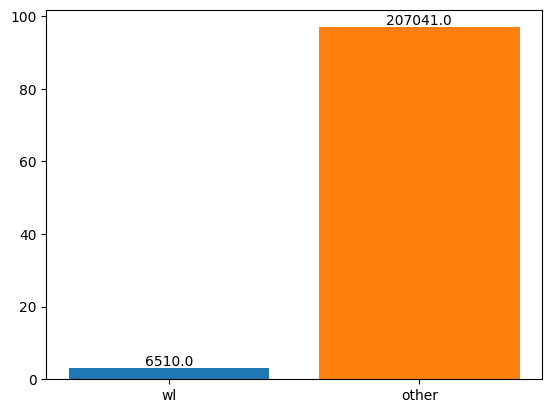

In [17]:
# the data is really imbalanced! we will need to deal with this if we use a random forest or xgboost
n_wl = y.sum()
n_other = len(y) - n_wl
ntot = len(y)

plt.bar(0, 100 * n_wl/ntot)
plt.bar(1, 100 * n_other/ntot)
plt.xticks([0, 1], ['wl', 'other'])

plt.text(0, 100 * n_wl/ntot, n_wl[0], ha='center', va='bottom')
plt.text(1, 100 * n_other/ntot, n_other[0], ha='center', va='bottom')

Text(0, 0.5, 'pca2')

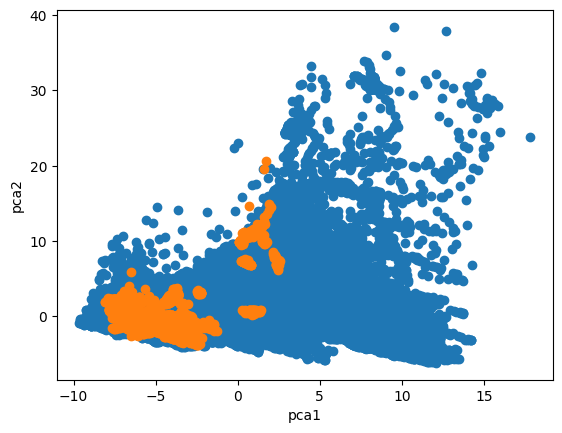

In [18]:
# there doesn't seem to be a clear, linear transformation that easily splits the data!
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
pipe.fit(X)
Z = pipe.transform(X)

isweak = y.astype(bool).values.reshape(-1)
plt.scatter(Z[~isweak, 0], Z[~isweak, 1])
plt.scatter(Z[isweak, 0], Z[isweak, 1])

plt.xlabel('pca1')
plt.ylabel('pca2')

Enough playing around - let's try a simple model and see what it brings.

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1), test_size=0.33, random_state=42069)
clf = XGBClassifier(max_depth=4)# scale_pos_weight=10)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [43]:
from sklearn.metrics import f1_score

# how does the model fare?
train_score = f1_score(y_train, clf.predict(X_train), )
test_score = f1_score(y_test, clf.predict(X_test))

print(f'training f1 score is {train_score:.2f}')
print(f'testing f1 score is {test_score:.2f}')

training f1 score is 0.99
testing f1 score is 0.97


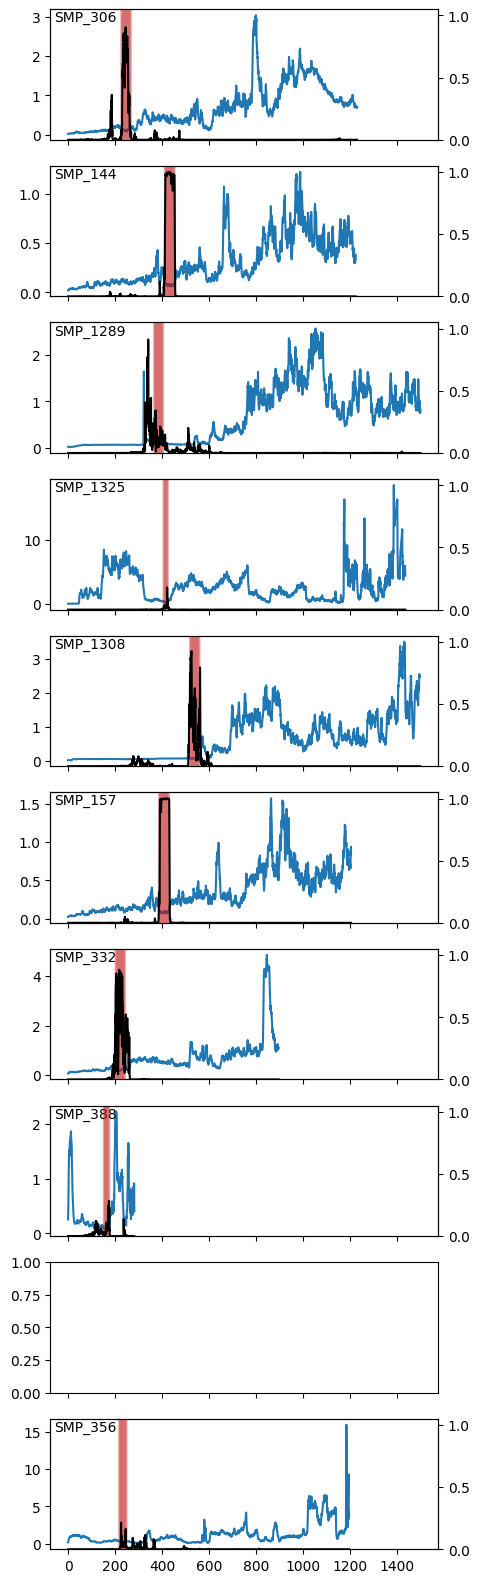

In [44]:
# the training and testing score are too good to be true! let's look at a few profiles to see what's going on
nsamples = 10
keys = list(val_profiles.keys())
keys = np.random.choice(keys, nsamples)

fig, axs = plt.subplots(nsamples, 1, sharex='all', figsize=(5, 2 * nsamples))
for i, key in enumerate(keys):

    profile = out[key]

    if 'layer' not in profile.columns:
        continue

    xi, yi = profile_to_data(profile, nwindow=nwindows)
    zi = pipe.transform(xi)
    yi_hat = clf.predict_proba(xi)[:, 1]

    ax = axs[i]
    ax.text(0.01, 0.99, key, ha='left', va='top', transform=ax.transAxes)
    ax.plot(profile['distance'], profile['force_median'])
    ax2 = ax.twinx()
    ax2.vlines(profile['distance'][yi.astype(bool)], 0, 1.05, colors='tab:red', alpha=0.05)
    ax2.plot(profile['distance'], yi_hat, c='k')
    ax2.set_ylim(0, 1.05)

In [30]:
X_val, y_val = pickle_to_data(val_profiles, nwindow=nwindows)
y_val = y_val.loc[X_val.index]
X_val

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  ret

,distance_mean_rolling_10,force_median_mean_rolling_10,fmax_mean_rolling_10,L2012_lambda_mean_rolling_10,L2012_f0_mean_rolling_10,L2012_delta_mean_rolling_10,L2012_L_mean_rolling_10,npeaks_mean_rolling_10,B2009_psi_mean_rolling_10,gradient_psi_mean_rolling_10,...,fmax_kurt_rolling_1000,L2012_lambda_kurt_rolling_1000,L2012_f0_kurt_rolling_1000,L2012_delta_kurt_rolling_1000,L2012_L_kurt_rolling_1000,npeaks_kurt_rolling_1000,B2009_psi_kurt_rolling_1000,gradient_psi_kurt_rolling_1000,delta_bellaire_kurt_rolling_1000,delta_bellairef5_kurt_rolling_1000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604995,0.995246,0.133759,0.151119,0.012819,0.155020,0.232697,0.531336,0.053330,0.202973,-0.006684,...,7.468459,5.577904,18.082576,9.644063,2.001357,1.993000,4.438908,5.499173,3.967909,41.69844
604996,0.995805,0.134973,0.151343,0.013584,0.151659,0.233166,0.525801,0.055207,0.201723,-0.006974,...,7.470930,5.645240,18.105825,9.662007,2.012076,2.026596,4.441783,5.501525,3.999006,41.69844
604997,0.996365,0.135223,0.151298,0.014585,0.148737,0.232611,0.520952,0.057431,0.200249,-0.017422,...,7.473024,5.652981,18.119765,9.663366,2.014927,2.032689,4.445030,5.510113,4.043605,41.69844
604998,0.996924,0.135474,0.151656,0.014341,0.146965,0.237947,0.522812,0.056823,0.194919,-0.018783,...,7.475155,5.703536,18.135868,9.695836,2.021256,2.060580,4.444981,5.502911,4.053379,41.69844


0.5932041685013943

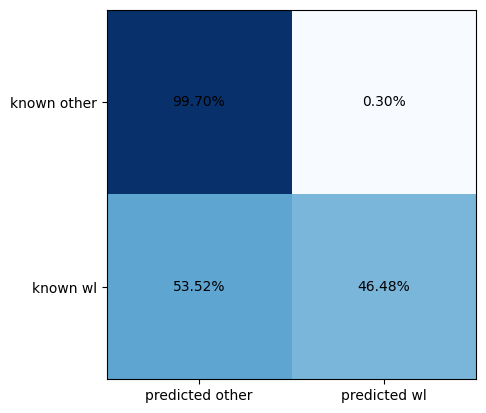

In [46]:
# the model picks the weak layer correctly, but it is probably uneable to generalize for now. let's look at the confusion matrix
from sklearn.metrics import confusion_matrix, f1_score

confmat = confusion_matrix(y_val, clf.predict(X_val), normalize='true')

fig, ax = plt.subplots()
ax.imshow(confmat, cmap='Blues')
ticks = np.arange(len(y.iloc[:, 0].unique()))
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_yticklabels(['known other', 'known wl'])
ax.set_xticklabels(['predicted other', 'predicted wl'])

for i in ticks:
    for j in ticks:
        ax.text(j, i, f'{100 * confmat[i, j]:.2f}%', ha='center', va='center')

f1 = f1_score(y_val, clf.predict(X_val))
f1

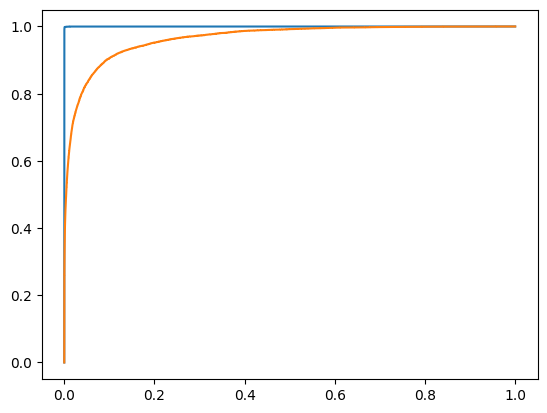

In [64]:
from sklearn.metrics import roc_curve
roc_train = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
roc_val = roc_curve(y_val, clf.predict_proba(X_val)[:, 1])
plt.plot(roc_train[0], roc_train[1])
plt.plot(roc_val[0], roc_val[1])

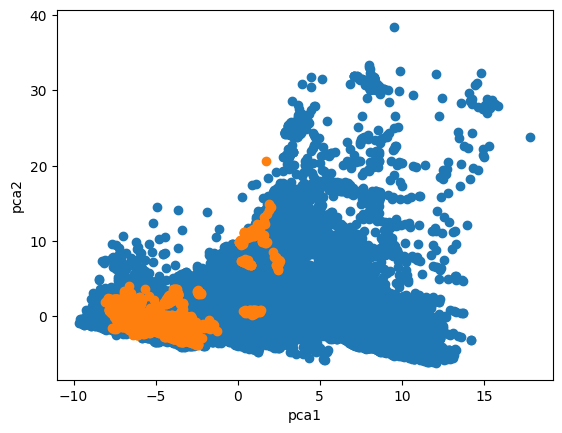

In [37]:
Z_train = pipe.transform(X_train)

isweak = y_train.astype(bool).reshape(-1)
plt.scatter(Z_train[~isweak, 0], Z_train[~isweak, 1])
plt.scatter(Z_train[isweak, 0], Z_train[isweak, 1])

plt.xlabel('pca1')
plt.ylabel('pca2')

xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

(-17.824803321897626, 30.647273486248974)

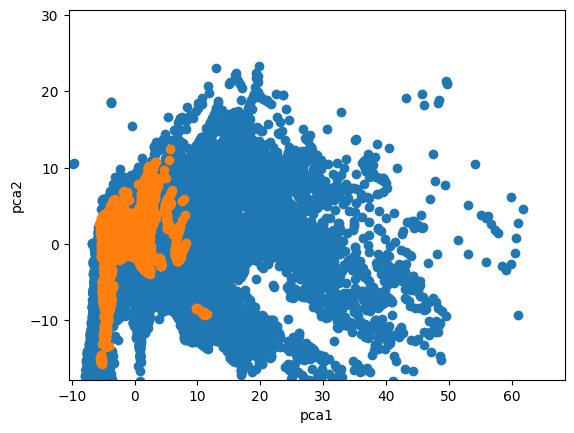

In [60]:
Z_val = pipe.transform(X_val)

isweak = y_val.astype(bool).values.reshape(-1)
plt.scatter(Z_val[~isweak, 0], Z_val[~isweak, 1])
plt.scatter(Z_val[isweak, 0], Z_val[isweak, 1])

plt.xlabel('pca1')
plt.ylabel('pca2')

plt.xlim(xlim)
plt.ylim(ylim)
